In [53]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
from blimpy import Waterfall
from blimpy.utils import rebin
from matplotlib import pyplot as plt
from bisect import bisect_left
from tqdm import tqdm
import dask.array as da
import h5py
from time import time

from utils import *

fil_path = "data/filterbanks/"
h5_path = "data/h5/"

test_fil = fil_path + "blc20_guppi_57991_48899_3C161_0007.gpuspec.0000.fil"

fri_obs = h5_path + "GBT_57532_09539_HIP56445_fine.h5"

plt_args = {
            'aspect':'auto',
            'origin':'lower',
            'rasterized':True,
            'interpolation':'nearest',
            'cmap':'viridis'
            }
# try:
#     client.close()
# except NameError:
#     pass
# from dask.distributed import Client, progress
# client = Client(processes=False, threads_per_worker=3,
#                 n_workers=4, memory_limit='8GB')
# client

In [54]:
# Show Info
wf = Waterfall(fri_obs, load_data=False)
wf.info()
header = wf.header

blimpy.file_wrapper INFO     Skipping loading data ...

--- File Info ---
b'DIMENSION_LABELS' : [b'frequency' b'feed_id' b'time']
     b'az_start' :                              0.0
    b'data_type' :                                1
         b'fch1' :                    1926.26953125
         b'foff' :           -2.835503418452676e-06
   b'machine_id' :                               20
        b'nbits' :                               32
       b'nchans' :                        318230528
         b'nifs' :                                1
  b'source_name' :                      b'HIP56445'
      b'src_dej' :                     3d03m34.006s
      b'src_raj' :                    11h34m21.699s
 b'telescope_id' :                                6
        b'tsamp' :                     17.986224128
       b'tstart' :                57532.11040509259
     b'za_start' :                              0.0

Num ints in file :                               16
      File shape :               (16,

In [55]:
freqs = wf.populate_freqs()

In [3]:
channel_len = 1033216
channel_len

1033216

In [ ]:
data = data[:, :16 * 1033216]
freqs = freqs[:16 * 1033216]

integrated = np.sum(data, axis=0)/len(data)
for n in np.nonzero(integrated > 10**13):
    integrated[n] = (integrated[n-1] + integrated[n+1]) /2
plt.figure()
plt.plot(freqs, np.log(integrated))


In [4]:
block21 = np.load("GBT_57532_09539_HIP56445_fine/cleaned/21.npy")

Downsampling by a factor of (1, 3531)


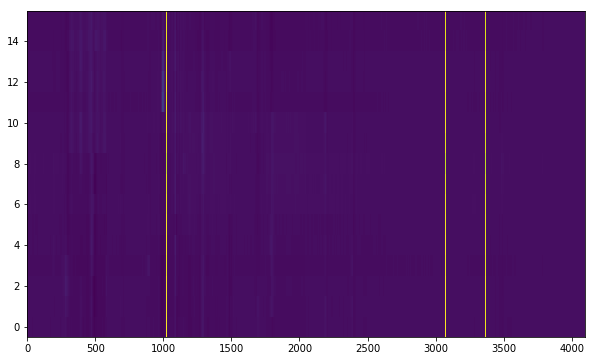

In [5]:
plot_segment(block21)

In [6]:
data = block21

In [ ]:
res = []
for chan in tqdm(range(14)):
    res.append([])
    window = data[:, channel_len*(chan):channel_len*(chan+1)]
    # window_f = freqs[channel_len*(chan):channel_len*(chan+1)]
    for i in range(0, (len(window[0])//200*200), 100):
        test_data = window[:, i:i+200]
        s, p = norm_test(test_data)
        if p < 1e-25:
            res[chan].append((i, s, p))

In [7]:
from multiprocessing import Pool
from time import time

import warnings
warnings.filterwarnings("ignore")


def threshold_hits(chan):
    res = list()
    window = data[:, channel_len*(chan):channel_len*(chan+1)]
    # window_f = freqs[channel_len*(chan):channel_len*(chan+1)]
    for i in range(0, (len(window[0])//200*200), 100):
        test_data = window[:, i:i+200]
        s, p = norm_test(test_data)
        if p < 1e-40:
            res.append([channel_len*(chan) + i, s, p])
    return res

start = time()
with Pool(12) as p:
    chan_hits = p.map(threshold_hits, range(14))
end = time()
print(end-start)

21.29619026184082


In [ ]:
sum([len(chan) for chan in chan_hits])

In [8]:
chan_hits

[[[242800, 4381.7882139565745, 0.0],
  [242900, 4379.439541471589, 0.0],
  [516500, 5932.893166200145, 0.0],
  [516600, 5932.893165647622, 0.0],
  [602500, 803.8334154575948, 2.8170311456745456e-175],
  [602600, 821.2762837498683, 4.5932588947561335e-179],
  [606800, 315.35957443929453, 3.31541961705859e-69],
  [606900, 332.3862368935786, 6.656496810779773e-73],
  [824400, 3668.038506271111, 0.0],
  [824500, 3669.229943625009, 0.0],
  [854400, 5379.807050645741, 0.0],
  [854500, 5370.798376525573, 0.0],
  [857300, 604.4415611556026, 5.587051551127856e-132],
  [857400, 617.6251844601737, 7.662936950022758e-135],
  [859400, 196.04788696113675, 2.683751202225618e-43],
  [859500, 200.47538811065607, 2.9330711155963247e-44],
  [860900, 966.9483175371926, 1.0711263519171416e-210],
  [861000, 995.1730716216528, 7.960002937441314e-217],
  [861800, 5017.246038217025, 0.0],
  [861900, 5017.065712972304, 0.0],
  [865400, 192.86389910319102, 1.3186709247300385e-42],
  [865500, 186.4204563500134, 3

In [9]:
collected = sum(chan_hits, [])

In [22]:
df = pd.DataFrame(collected, columns=["index", "statistic", "pvalue"])
df["num"] = np.arange(2616)
df

index    statistic         pvalue   num
0       242800  4381.788214   0.000000e+00     0
1       242900  4379.439541   0.000000e+00     1
2       516500  5932.893166   0.000000e+00     2
3       516600  5932.893166   0.000000e+00     3
4       602500   803.833415  2.817031e-175     4
...        ...          ...            ...   ...
2611  13740208  3069.314525   0.000000e+00  2611
2612  13740508   249.485305   6.682737e-55  2612
2613  13740608   283.567870   2.654724e-62  2613
2614  13948308  5932.885392   0.000000e+00  2614
2615  13948408  5932.885392   0.000000e+00  2615

[2616 rows x 4 columns]

In [24]:
df2 = df.copy()
df2["index"]+=20
df2

index    statistic         pvalue   num
0       242820  4381.788214   0.000000e+00     0
1       242920  4379.439541   0.000000e+00     1
2       516520  5932.893166   0.000000e+00     2
3       516620  5932.893166   0.000000e+00     3
4       602520   803.833415  2.817031e-175     4
...        ...          ...            ...   ...
2611  13740228  3069.314525   0.000000e+00  2611
2612  13740528   249.485305   6.682737e-55  2612
2613  13740628   283.567870   2.654724e-62  2613
2614  13948328  5932.885392   0.000000e+00  2614
2615  13948428  5932.885392   0.000000e+00  2615

[2616 rows x 4 columns]

In [47]:
cat = pd.concat([df, df2],ignore_index=True).set_index(["index"])
cat

statistic         pvalue   num
index                                     
242800    4381.788214   0.000000e+00     0
242900    4379.439541   0.000000e+00     1
516500    5932.893166   0.000000e+00     2
516600    5932.893166   0.000000e+00     3
602500     803.833415  2.817031e-175     4
...               ...            ...   ...
13740228  3069.314525   0.000000e+00  2611
13740528   249.485305   6.682737e-55  2612
13740628   283.567870   2.654724e-62  2613
13948328  5932.885392   0.000000e+00  2614
13948428  5932.885392   0.000000e+00  2615

[5232 rows x 3 columns]

In [50]:
cat["num2"] = cat["num"].apply(lambda x: x*2)
cat.sort_index()

statistic        pvalue   num  num2
index                                          
242800    4381.788214  0.000000e+00     0     0
242820    4381.788214  0.000000e+00     0     0
242900    4379.439541  0.000000e+00     1     2
242920    4379.439541  0.000000e+00     1     2
516500    5932.893166  0.000000e+00     2     4
...               ...           ...   ...   ...
13740628   283.567870  2.654724e-62  2613  5226
13948308  5932.885392  0.000000e+00  2614  5228
13948328  5932.885392  0.000000e+00  2614  5228
13948408  5932.885392  0.000000e+00  2615  5230
13948428  5932.885392  0.000000e+00  2615  5230

[5232 rows x 4 columns]

Downsampling by a factor of (1, 1)


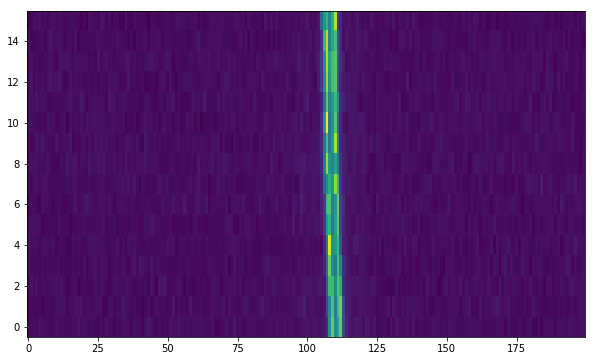

In [51]:
left = 824400
plot_segment(block21[:, left:left+200])

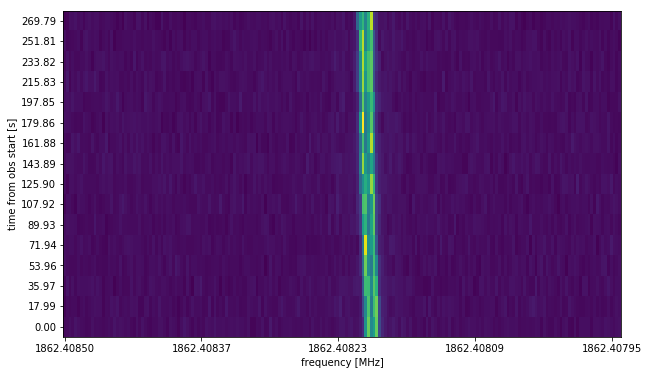

In [56]:
sub_freqs = freqs[21*channel_len+left:21*channel_len+left+201]
plt.figure(figsize=(10, 6))
plt.yticks(np.arange(0, 16), list(map(lambda x: "%.2f" % x, np.arange(0, wf.header[b'tsamp']*18, wf.header[b'tsamp']))))
plt.xticks(np.arange(0, 200, 49), list(map(lambda x: "%.5f" % x, sub_freqs[np.arange(0, 200, 49)])))
plt.ylabel("time from obs start [s]")
plt.xlabel("frequency [MHz]")
plt.imshow(rebin(block21[:, left:left+200], 1, 1), **plt_args)

In [ ]:
foff = freqs[1] - freqs[0]
foff, a, b
np.arange(b, a, -foff*100)

In [ ]:
show_stamp_f(freqs, data, 1025.0100805927195)

In [ ]:
hits = [len(e) for e in chan_hits]
print(hits)
print(sum(hits))

In [ ]:
sorted_hits = sorted(res[7], key=lambda x: x[2])
sorted_hits

In [ ]:
top = [x[0] for x in sorted_hits[:20]]
top

In [ ]:
for i in top:
    print(i)
    show_stamp(window, i)

In [ ]:
res[:15]

In [ ]:
plt.figure()
plt.imshow(data[:, 8:8+128])

In [ ]:
with open("pfb512coef.txt", "r") as f:
    coef_file = f.read()

In [ ]:
lines = coef_file.splitlines()
filter_coefs = []
for line in lines:
    filter_coefs.append(float(line))

In [ ]:
coefs = np.array(filter_coefs)/2**17

In [ ]:
plt.figure()
plt.plot(coefs)

In [ ]:
from numpy import fft
l = 2**16
f = fft.fft(coefs, l)
plt.figure()
plt.plot(np.log(np.abs(f)**2))

In [ ]:
stacked = np.reshape(integrated, (15, 1033216))
plt.figure()
for i in range(15):
    plt.plot(np.log(stacked[i]))

In [ ]:
rebined = rebin(stacked, 1, 64)

In [ ]:
plt.figure()
plt.imshow(np.log(rebined), **plt_args)

In [ ]:
model_shape = np.sum(stacked, axis=0)/15
model_shape[model_shape > 10**10] = np.mean(model_shape)

In [ ]:
plt.figure()
plt.plot(model_shape)

In [ ]:
h5_file = h5py.File(fri_obs, "r")
a = da.from_array(h5_file["data"], chunks=(2, 1, channel_len*14))
a = a
a

In [ ]:
data = h5_file["data"][:,:,:28413432+2000]


In [ ]:
plot_segment(data[:, 0, 18082772:18082772+200])

In [ ]:
start = time()
a.persist()
da.to_npy_stack("original_a", a, axis=2)
end = time()
print(f"{end-start}")

In [ ]:
a = da.from_npy_stack("original_a")
a

In [ ]:
start = time()
means = da.mean(a, axis=2)
# means_data = means.compute()
# means_data
end = time()

print(f"{end-start}")
means = da.reshape(means, (16,1,1))
means

In [ ]:
a

In [ ]:
308/14

In [ ]:
normalized_a = da.divide(a, means)
normalized_a

In [ ]:
start = time()

da.to_npy_stack('normalized_a/', normalized_a, axis=2)

end = time()

print(f"{end-start}")

In [ ]:
print(normalized_a.shape)
print(normalized_a.chunks)

In [ ]:
start = time()
normalized_a_data = normalized_a.compute()
end = time()
print(f"{end-start}")

In [ ]:
start = time()

original_a_data = a[:, 0, :16 * 1033216].compute()

end = time()
print(f"{end-start}")

In [ ]:
read_a = da.from_array(original_a_data)
read_and_normalize = da.divide(read_a, means_data)

start = time()
normalized_a_data = read_and_normalize.compute()
end = time()
print(f"{end-start}")

# 1.6420118808746338

In [ ]:
del normalized_a_data

In [ ]:
start = time()

numpy_normalized_a_data = original_a_data / means_data

end = time()
print(f"{end-start}")

# 0.6659681797027588

In [ ]:
del numpy_normalized_a_data

In [ ]:
numpy_normalized_a_data.shape

In [ ]:
plot_segment(normalized_a_data)

In [ ]:
plot_segment(original_a_data)

In [ ]:
print(normalized_a_data.shape == numpy_normalized_a_data.shape)
print(np.allclose(normalized_a_data, numpy_normalized_a_data))